In [1]:
import pandas as pd

import numpy as np

from scipy.signal import welch

from scipy.stats import skew, kurtosis

from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

from sklearn import svm

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold, cross_validate

from sklearn.metrics import make_scorer, f1_score

from sklearn.model_selection import cross_val_score, StratifiedKFold

In [2]:
df = pd.read_csv('../datasets/final/imu_data_filtered.csv')

In [3]:
def sliding_window(df, window_size):
    
    groups = []
    
    current_group = []
    
    current_surface = None  

    for index, row in df.iterrows():
        
        if current_surface is None:
            
            current_surface = row['surface']  

        if row['surface'] == current_surface:
            
            current_group.append((row['filtered accelerometer'], row['gyro']))

            if len(current_group) == window_size:
                
                groups.append((current_group, current_surface)) 
                
                current_group = [] 

        else:
            
            if len(current_group) == window_size:
                
                groups.append((current_group, current_surface))

            current_group = [(row['filtered accelerometer'], row['gyro'])]
            
            current_surface = row['surface']
            
    if len(current_group) == window_size:
        
        groups.append((current_group, current_surface))

    return groups

In [4]:
def calculate_mean(data):
    
    accelerometer_mean = np.mean([x[0] for x in data[0]])
    
    gyro_mean = np.mean([x[1] for x in data[0]])
    
    return accelerometer_mean, gyro_mean

def calculate_std(data):
    
    accelerometer_std = np.std([x[0] for x in data[0]])  
    
    gyro_std = np.std([x[1] for x in data[0]]) 
    
    return accelerometer_std, gyro_std

def calculate_max(data):
    
    accelerometer_max = np.max([x[0] for x in data[0]]) 
    
    gyro_max = np.max([x[1] for x in data[0]])  
    
    return accelerometer_max, gyro_max

def calculate_min(data):
    
    accelerometer_min = np.min([x[0] for x in data[0]]) 
    
    gyro_min = np.min([x[1] for x in data[0]]) 
    
    return accelerometer_min, gyro_min

def calculate_iqr(data):
    
    accelerometer_iqr = np.percentile([x[0] for x in data[0]], 75) - np.percentile([x[0] for x in data[0]], 25)
    
    gyro_iqr = np.percentile([x[1] for x in data[0]], 75) - np.percentile([x[1] for x in data[0]], 25)
    
    return accelerometer_iqr, gyro_iqr

def calculate_skewness(data):
    
    accelerometer_skew = skew([x[0] for x in data[0]])
    
    gyro_skew = skew([x[1] for x in data[0]])
    
    return accelerometer_skew, gyro_skew

def calculate_kurtosis(data):
    
    accelerometer_kurt = kurtosis([x[0] for x in data[0]])
    
    gyro_kurt = kurtosis([x[1] for x in data[0]])
    
    return accelerometer_kurt, gyro_kurt
    
def calculate_fft_peak(data):
    
    fft_acc = np.fft.fft([x[0] for x in data[0]])
    
    fft_gyro = np.fft.fft([x[1] for x in data[0]])
    
    mag_acc = np.abs(fft_acc)
    
    mag_gyro = np.abs(fft_gyro)
    
    peak_index_acc = np.argmax(mag_acc)
    
    peak_index_gyro = np.argmax(mag_gyro)
    
    peak_amplitude_acc = mag_acc[peak_index_acc]
    
    peak_amplitude_gyro = mag_gyro[peak_index_gyro]
    
    return peak_amplitude_acc, peak_amplitude_gyro

def calculate_psd(data):
    
    accelerometer_data = np.array([x[0] for x in data[0]])
    
    gyro_data = np.array([x[1] for x in data[0]])

    f_acc, psd_acc = welch(accelerometer_data, fs=100, nperseg=100)  
    
    f_gyro, psd_gyro = welch(gyro_data, fs=100, nperseg=100)  

    peak_freq_acc = f_acc[np.argmax(psd_acc)]
    
    peak_power_acc = np.max(psd_acc)
    
    peak_freq_gyro = f_gyro[np.argmax(psd_gyro)]
    
    peak_power_gyro = np.max(psd_gyro)

    return peak_freq_acc, peak_power_acc, peak_freq_gyro, peak_power_gyro

def extract_surface(data):

    surface = data[1]

    return surface

In [5]:
def extract_features(segments):
    
    features_list = []
    
    for segment in segments:

        psd_features = calculate_psd(segment)
        
        features = {
            'accelerometer_mean': calculate_mean(segment)[0],
            'gyro_mean': calculate_mean(segment)[1],
            'accelerometer_std': calculate_std(segment)[0],
            'gyro_std': calculate_std(segment)[1],
            'accelerometer_max': calculate_max(segment)[0],
            'gyro_max': calculate_max(segment)[1],
            'accelerometer_min': calculate_min(segment)[0],
            'gyro_min': calculate_min(segment)[1],
            'accelerometer_iqr': calculate_iqr(segment)[0],
            'gyro_iqr': calculate_iqr(segment)[1],
            'accelerometer_skewness': calculate_skewness(segment)[0],
            'gyro_skewness': calculate_skewness(segment)[1],
            'accelerometer_kurtosis': calculate_kurtosis(segment)[0],
            'gyro_kurtosis': calculate_kurtosis(segment)[1],
            'accelerometer_fft_peak_amplitude': calculate_fft_peak(segment)[0],
            'gyro_fft_peak_amplitude': calculate_fft_peak(segment)[1],
            'accelerometer_peak_freq': psd_features[0],
            'accelerometer_peak_power': psd_features[1],
            'gyro_peak_freq': psd_features[2],
            'gyro_peak_power': psd_features[3],
            'surface': extract_surface(segment)
        }
        features_list.append(features)
    
    return features_list

In [6]:
window_size_list = range(100, 700, 100)

In [7]:
encoder = OrdinalEncoder()

scaler = StandardScaler()

just_some_list = []

for i in window_size_list:

    window_data_list = sliding_window(df, i)

    features_list = extract_features(window_data_list)

    features_df = pd.DataFrame(features_list)

    features_df['surface_encoded'] = encoder.fit_transform(features_df[['surface']])

    features_df = features_df.drop('surface', axis = 1)

    X = features_df.drop('surface_encoded', axis = 1)

    y = features_df['surface_encoded']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

    X_train_scaled = scaler.fit_transform(X_train)

    X_test_scaled = scaler.transform(X_test)
        
    svm_classifier = SVC(kernel = 'linear')

    svm_classifier.fit(X_train_scaled, y_train)

    y_pred = svm_classifier.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)

    f1 = f1_score(y_test, y_pred, average='weighted')

    new_list = {

        'window size': i,

        'accuracy' : accuracy

    }

    just_some_list.append(new_list) 

In [8]:
df2 = pd.DataFrame(just_some_list)

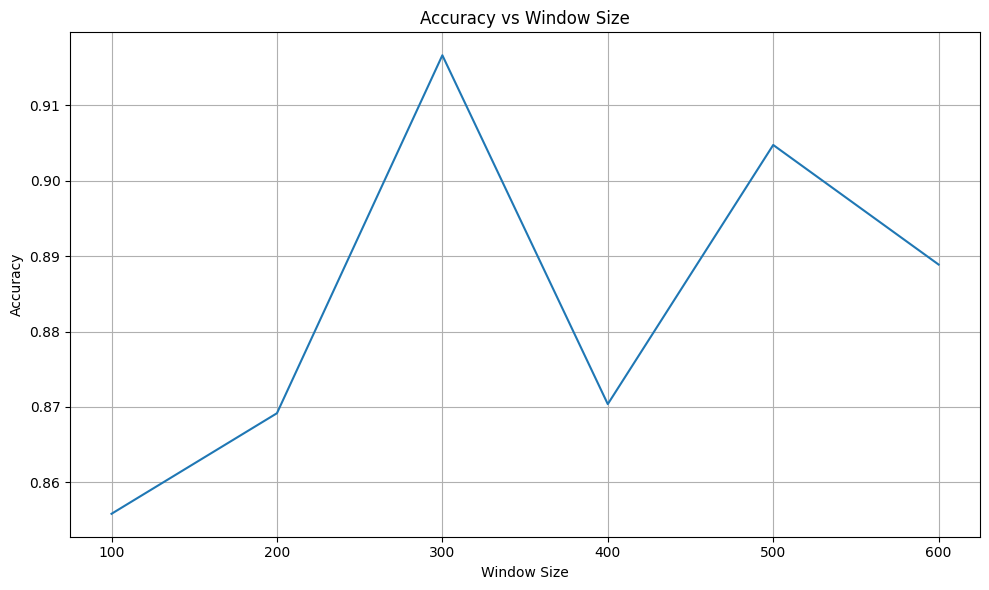

In [9]:
plt.figure(figsize = (10,6))

plt.plot(df2['window size'], df2['accuracy'])

plt.xlabel('Window Size')

plt.ylabel('Accuracy')

plt.title('Accuracy vs Window Size')


plt.grid(True)

plt.tight_layout()

plt.show()

In [10]:
window_data_list = sliding_window(df, 300)

features_list = extract_features(window_data_list)

In [11]:
features_df = pd.DataFrame(features_list)

In [12]:
encoder = OrdinalEncoder()

features_df['surface_encoded'] = encoder.fit_transform(features_df[['surface']])

In [13]:
features_df = features_df.drop('surface', axis = 1)

In [14]:
X = features_df.drop('surface_encoded', axis = 1)

y = features_df['surface_encoded']

In [51]:
clf = SVC(kernel = 'linear', random_state = 42)

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

pipeline = make_pipeline(StandardScaler(), clf)

cv_scores = cross_val_score(pipeline, X, y, cv = skf, scoring = 'accuracy')

print(cv_scores)

print(np.mean(cv_scores))

[0.85416667 0.89583333 0.87234043 0.95744681 0.95744681]
0.9074468085106384


In [52]:
f1_scores = cross_val_score(pipeline, X, y, cv = skf, scoring = 'f1_macro')

print(f1_scores)

print(np.mean(f1_scores))

[0.86039966 0.89543711 0.87863636 0.95866136 0.95777778]
0.9101824541202654


Number of components explaining at least 95% of the variance: 9


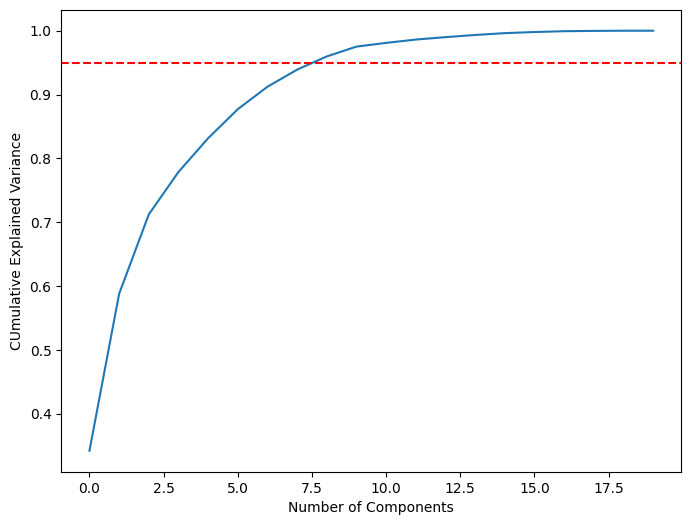

In [53]:
pca = PCA()

pca.fit(X_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

n_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Number of components explaining at least 95% of the variance: {n_components}")

plt.figure(figsize = (8, 6))

plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('Number of Components')

plt.ylabel('CUmulative Explained Variance')

plt.axhline(y = 0.95, color = 'r', linestyle = '--')

plt.show()

In [54]:
pipeline2 = make_pipeline(StandardScaler(), PCA(n_components = 9), clf)

cv_scores2 = cross_val_score(pipeline2, X, y, cv = skf, scoring = 'accuracy')

print(cv_scores2)

print(np.mean(cv_scores2))

[0.875      0.91666667 0.82978723 0.9787234  0.91489362]
0.9030141843971631


In [56]:
f1_scores2 = cross_val_score(pipeline2, X, y, cv = skf, scoring = 'f1_macro')

print(f1_scores2)

print(np.mean(f1_scores2))

[0.88097046 0.91733041 0.83066865 0.97871148 0.91611111]
0.9047584232222811
